 # Libraries

In [1]:
# libraries

import cv2
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Image Properties

Let's loop through the training and test data and grab some summary statistics about the images:

- Height
- Width
- Height to Width Ratio
- Total Number of Pixels
- Total Number of Black Pixels
- Total Proportion of Black Pixels
- Channel Means

In [2]:
# training features

train = pd.read_csv('../input/train.csv')
train_results = []

for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    img = cv2.imread('../input//train_images/{}.png'.format(row['id_code']))

    height, width, channels = img.shape
    ratio = width/height
    pixel_count = width*height
    gray_scaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    black_cnt = pixel_count-cv2.countNonZero(gray_scaled)
    black_pct = black_cnt/pixel_count
    mean0, mean1, mean2, _ = cv2.mean(img)

    observation = np.array(
        (row['diagnosis'], height, width, ratio, pixel_count, black_cnt, black_pct, mean0, mean1, mean2))

    train_results.append(observation)

train_results_df = pd.DataFrame(train_results)
train_results_df.columns = [
    'diagnosis','height','width','ratio','pixel_count','black_cnt','black_pct','mean_c0','mean_c1','mean_c2']

In [3]:
# test features

test = pd.read_csv('../input/test.csv')
test_results = []

for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    img = cv2.imread('../input//test_images/{}.png'.format(row['id_code']))

    height, width, channels = img.shape
    ratio = width/height
    pixel_count = width*height
    gray_scaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    black_cnt = pixel_count-cv2.countNonZero(gray_scaled)
    black_pct = black_cnt/pixel_count
    mean0, mean1, mean2, _ = cv2.mean(img)

    observation = np.array(
        (np.nan, height, width, ratio, pixel_count, black_cnt, black_pct, mean0, mean1, mean2))

    test_results.append(observation)

test_results_df = pd.DataFrame(test_results)
test_results_df.columns = [
    'diagnosis','height','width','ratio','pixel_count','black_cnt','black_pct','mean_c0','mean_c1','mean_c2']

# Model

Let's see what kind of score we get using just meta features of the images. The higher the score, the more worried we need to be about our models picking up information irrelevant for the purpose of diagnosis.

In [4]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'eta': 0.005,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'tree_method': 'gpu_hist',
    'num_class': 5}

In [5]:
X = train_results_df.drop(columns=['diagnosis'])
y = train_results_df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100000,
    evals=watchlist,
    early_stopping_rounds=250,
    verbose_eval=100
)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mlogloss:1.60152	valid-mlogloss:1.60248
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 250 rounds.
[100]	train-mlogloss:1.06517	valid-mlogloss:1.16165
[200]	train-mlogloss:0.784988	valid-mlogloss:0.960947
[300]	train-mlogloss:0.61699	valid-mlogloss:0.859099
[400]	train-mlogloss:0.504557	valid-mlogloss:0.806429
[500]	train-mlogloss:0.425816	valid-mlogloss:0.779085
[600]	train-mlogloss:0.372285	valid-mlogloss:0.765768
[700]	train-mlogloss:0.331406	valid-mlogloss:0.763042
[800]	train-mlogloss:0.298271	valid-mlogloss:0.764216
[900]	train-mlogloss:0.275094	valid-mlogloss:0.768548
Stopping. Best iteration:
[732]	train-mlogloss:0.319872	valid-mlogloss:0.762261



In [6]:
pred = pd.DataFrame(np.argmax(bst.predict(dvalid), axis=1))
results = pd.concat([y_test.reset_index(drop=True), pred], axis=1)
score = cohen_kappa_score(results.iloc[:,0], results.iloc[:,1], weights="quadratic")

print('Validation Kappa:', score)

Validation Kappa: 0.704344795331393


[Text(30.5, 0.5, 'True label'), Text(0.5, 12.5, 'Predicted label')]

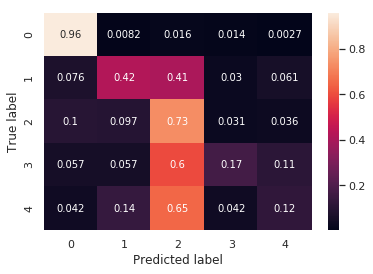

In [7]:
cm = confusion_matrix(y_true=results.iloc[:,0], y_pred=results.iloc[:,1])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True)
ax.set(ylabel='True label', xlabel='Predicted label')

Classes 0-2 can be predicted extremely well using just the image meta data. What proportion of the data do they make up?


In [8]:
train['diagnosis'].value_counts()/train.shape[0]

0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64

So approximately 90% of the data. Uh-oh. This is not looking good. But what features is it exactly? Let's look at the feature importance.

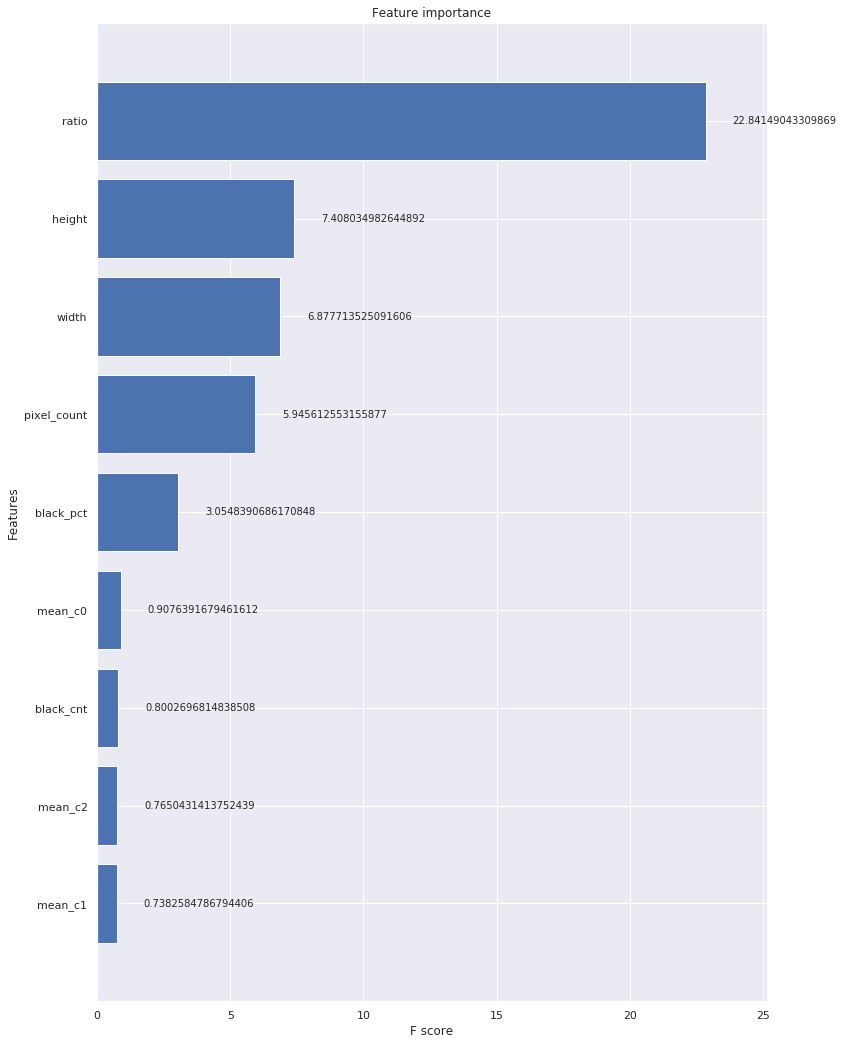

In [9]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, importance_type='gain', height=0.8, ax=ax)

It seems the most important feature is the image size, specifically the ratio of height to width. Now, when running our models we often resize to e.g. 224x224, so is this a problem? Let's start by looking at the ratios present in the training data.

In [10]:
train_results_df.groupby(['ratio', 'diagnosis'])['pixel_count'].count()

ratio     diagnosis
1.000000  0.0          901
          1.0           19
          2.0           39
          3.0            2
          4.0           13
1.216553  3.0            1
1.309119  1.0           13
          2.0           91
          3.0            6
          4.0           31
1.321397  0.0           10
          3.0            2
          4.0            2
1.321622  2.0            2
1.321757  0.0          231
          1.0           44
          2.0          165
          3.0           47
          4.0           46
1.324022  2.0            1
          4.0            1
1.333333  0.0          351
          2.0           33
          3.0            5
          4.0            4
1.333876  0.0          279
          1.0            7
          2.0            1
1.391705  0.0           31
          1.0          234
          2.0          233
          3.0           60
          4.0           80
1.489712  1.0            6
          2.0            3
          3.0           21
        

You can clearly see the effect here. Square images are nearly always class zero, while some of the rectangular images have far higher numbers of higher classes (look at 1.505618!). 

But does this matter if we resize? Yes, it will. To labour the point, let's take an image from r={1.000000, 1.333333, 1.505618} and re-size.

(-0.5, 3215.5, 2135.5, -0.5)

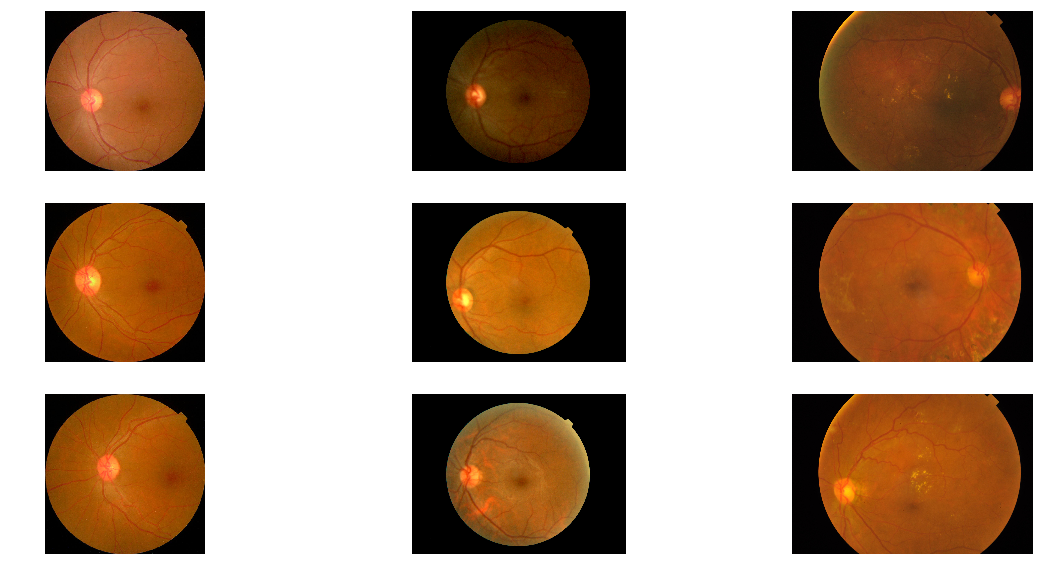

In [11]:

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))

img0a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[0], 0]))

ax[0,0].imshow(cv2.cvtColor(img0a, cv2.COLOR_BGR2RGB))
ax[0,0].axis('off')

img0b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[1], 0]))

ax[1,0].imshow(cv2.cvtColor(img0b, cv2.COLOR_BGR2RGB))
ax[1,0].axis('off')

img0c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[2], 0]))

ax[2,0].imshow(cv2.cvtColor(img0c, cv2.COLOR_BGR2RGB))
ax[2,0].axis('off')

img1a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[0], 0]))

ax[0,1].imshow(cv2.cvtColor(img1a, cv2.COLOR_BGR2RGB))
ax[0,1].axis('off')

img1b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[1], 0]))

ax[1,1].imshow(cv2.cvtColor(img1b, cv2.COLOR_BGR2RGB))
ax[1,1].axis('off')

img1c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[2], 0]))

ax[2,1].imshow(cv2.cvtColor(img1c, cv2.COLOR_BGR2RGB))
ax[2,1].axis('off')

img2a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[0], 0]))

ax[0,2].imshow(cv2.cvtColor(img2a, cv2.COLOR_BGR2RGB))
ax[0,2].axis('off')

img2b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[1], 0]))

ax[1,2].imshow(cv2.cvtColor(img2b, cv2.COLOR_BGR2RGB))
ax[1,2].axis('off')

img2c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[2], 0]))

ax[2,2].imshow(cv2.cvtColor(img2c, cv2.COLOR_BGR2RGB))
ax[2,2].axis('off')

Now let's resize to 224x224

(-0.5, 223.5, 223.5, -0.5)

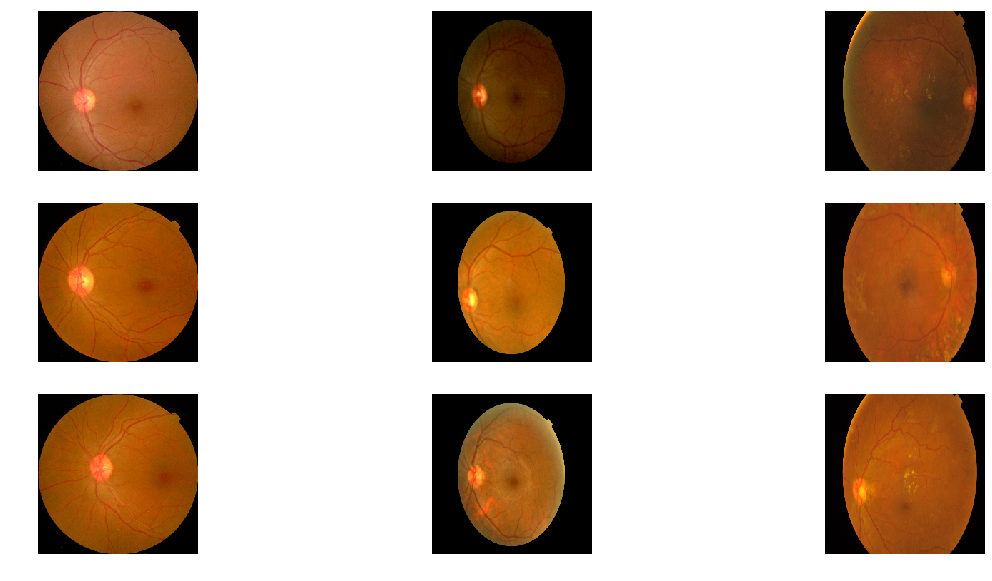

In [12]:

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))

img0a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[0], 0]))
img0a = cv2.resize(img0a, (224,224))
ax[0,0].imshow(cv2.cvtColor(img0a, cv2.COLOR_BGR2RGB))
ax[0,0].axis('off')

img0b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[1], 0]))
img0b = cv2.resize(img0b, (224,224))
ax[1,0].imshow(cv2.cvtColor(img0b, cv2.COLOR_BGR2RGB))
ax[1,0].axis('off')

img0c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.000000].index[2], 0]))
img0c = cv2.resize(img0c, (224,224))
ax[2,0].imshow(cv2.cvtColor(img0c, cv2.COLOR_BGR2RGB))
ax[2,0].axis('off')

img1a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[0], 0]))
img1a = cv2.resize(img1a, (224,224))
ax[0,1].imshow(cv2.cvtColor(img1a, cv2.COLOR_BGR2RGB))
ax[0,1].axis('off')

img1b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[1], 0]))
img1b = cv2.resize(img1b, (224,224))
ax[1,1].imshow(cv2.cvtColor(img1b, cv2.COLOR_BGR2RGB))
ax[1,1].axis('off')

img1c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.333333].index[2], 0]))
img1c = cv2.resize(img1c, (224,224))
ax[2,1].imshow(cv2.cvtColor(img1c, cv2.COLOR_BGR2RGB))
ax[2,1].axis('off')

img2a = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[0], 0]))
img2a = cv2.resize(img2a, (224,224))
ax[0,2].imshow(cv2.cvtColor(img2a, cv2.COLOR_BGR2RGB))
ax[0,2].axis('off')

img2b = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[1], 0]))
img2b = cv2.resize(img2b, (224,224))
ax[1,2].imshow(cv2.cvtColor(img2b, cv2.COLOR_BGR2RGB))
ax[1,2].axis('off')

img2c = cv2.imread(
    '../input/train_images/{}.png'.format(train.iloc[train_results_df[np.round(train_results_df['ratio'], 6)==1.505618].index[2], 0]))
img2c = cv2.resize(img2c, (224,224))
ax[2,2].imshow(cv2.cvtColor(img2c, cv2.COLOR_BGR2RGB))
ax[2,2].axis('off')

If this was the only pre-processing we did, it would not be hard for a deep CNN to learn to differentiate classes based on the eyeball edges and the space surrounding them.

For an example of where the model can go wrong in this way have a look at the excellent kernel by [dimitreoliveira](https://www.kaggle.com/dimitreoliveira) here:

https://www.kaggle.com/dimitreoliveira/diabetic-retinopathy-shap-model-explainability

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1182060%2F4cc45db867d9ec1b983c353c7f23b633%2Fshap.PNG?generation=1563462787163185&alt=media)

We clearly see here that the model tends in part to focus on what is going on around the edge of the eyeball, and who can blame it? It's a great way to make predictions in the training data.
An important thing to note here is that this weird relationship between meta-features and target does **NOT** extend to the test data. Let's generate predictions to demonstrate this:

In [13]:
dtest = xgb.DMatrix(test_results_df.drop(columns=['diagnosis']))
test_pred = pd.DataFrame(np.argmax(bst.predict(dtest), axis=1))
submission = pd.concat([test['id_code'], test_pred], axis=1)
submission.columns = ['id_code','diagnosis']
submission.to_csv('submission.csv', index=False)
submission.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
